In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
from scipy.stats import gamma # gamma(a, begin_time, b)
from random import random as rand
from math import log
from skimage.io import imread,imshow
from skimage.transform import resize
from functools import reduce
from operator import add
from itertools import *
matplotlib.rcParams["figure.figsize"] = 9., 6.

** Problem we're solving **

Our project's first direction is to take ideas from discrete kernel estimation and apply them to estimating rate functions for nonhomogeneous poisson processes.

A typical discrete nonparametric estimator gives a cumulative probability function p(x) = sum( f(x_i, x) , for i in [1..n]). The type and radius of kernel function to use are both hyperparameters this kind of estimation.

Shown below are typical kernel functions, the most significant is the Epachnikov, which minimizes the mean squared error for many well behaved distributions.

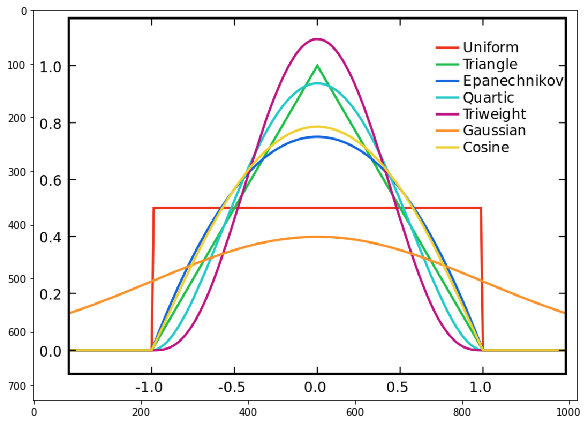

courtesy wikipedia.org


In [2]:
imshow(imread('kernels.png')); plt.show(); print("courtesy wikipedia.org")

** Example of estimator using the epachnikov kernel function r=1 **

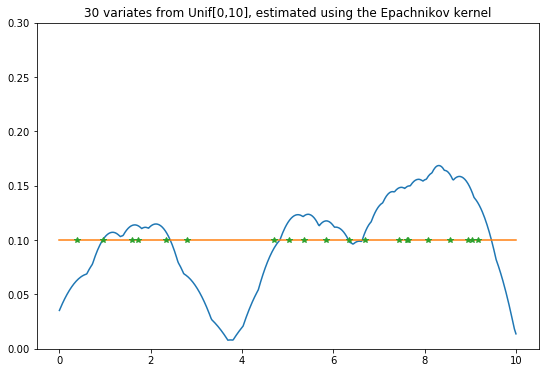

In [3]:
from numpy import maximum as m

def estimator(x_observed, radius):
    s= 'lambda x: (1./%d' % len(x_observed) + \
        ') * (' + reduce(add, ['m(0,3.*(1-((%f-x)/(%f))**2)/4) + \\\n' % \
        (x_observed[i], radius) for i in range(len(x_observed))] + ['0.)'])
   # print s
    return eval(s) # python magic

n = 20
b = 10
data, x = 10*np.random.random((n,)), np.linspace(0,10,600)
#data, x = all_arrivals, np.linspace(0,12,300)
est = estimator(data, 1)

plt.plot(x, list(map(est, x)))
plt.plot(x, [1./b]*600)
plt.ylim([0,.3])
plt.plot(data, [1./b]*20, "*")
plt.title("30 variates from Unif[0,10], estimated using the Epachnikov kernel")
plt.show()



** Minimizing Cross Entropy **

This distribution has very high cross entropy when compared to Unif[0,10], so providing a principled approach to nonparametric estimation will turn out very important especially when modelling a stochastic process (whose parameters may follow random walks).

Also notice the drop off of probability density at the ends of the interval. A revenue management system that didn't correct for this would erroneously predict much lower demand (on average about a factor of half) at the end.

** Intensity Estimation **

An estimate for the rate function of a NHPP given observed data should have integral equal to the number of points observed (for the stndard MLE approach) instead of an integral of one as in typical nonparametric estimation methods.

** Need for a robust estimator **

As can be viewed from the previous plot, nonparametric methods fail in the presence of low amounts of data. In industry when cyclical demand fluctuations are observed, the constant rate MLE estimate is insuficcient. In inventory problems they may run out too quickly or miss an opportunity to raise prices.

In our research for a robust estimator we will be able to calculate cross entropy of the estimated intensity function and the actual intensity function simply by normalizing them to integrate to 1.

We will try to find heuristics to find optimal kernel width and types of kernel functions.

** Need for generated data **

The previous result of uncommonly high entropy for even a small sample size is very common. Without first using generated data to devise heuristics for kernel sizes and kernel function types we would not be able to establish convergence in distribution.

**Thinning, a computationally efficient means of sampling NHPPs**

In [4]:
# Generate by thinning from a strictly dominating homogeneous poisson process
# Needs two separate Unif[0,1] variates
def gen_NHPP_thinning(rate_func, a, b, rate_max):
    """ rate_func: is a rate function over (a,b)
        a,b: The open interval on which to sample our process
        l_max: a close upper bound of l over (a,b) """
    result, x_ = [], a
    
    while x_ < b:
        u1, u2 = rand(), rand()
        
        x_ += -log(u1)/rate_max # inverse of interarrival cdf for homogeneous PP
        p_keep = rate_func(x_) / rate_max
        if u2 < p_keep:
            result += [x_]

    return result[:-1] # last one is outside (a,b)

def get_homogeneous_PP(rate, a, b):
    n_samples = int(2.*(b-a)/(1.*rate))
    points = np.cumsum(gamma(1, a, rate).rvs(size=n_samples))
    return filter(lambda x:x<b, points)

def plot(res, bins, f, title="", a=None, b=None):
    res,_ = list(res),pd.DataFrame({"(Possibly) Stacked Arrival Times": res}).plot(kind="hist", bins=bins)
    if a is None and b is None:
        a,b = min(res), max(res)
    print(a,b)
    plt.plot(np.linspace(a, b, 200), list(map(f, np.linspace(a, b, 200))))
    plt.title(title);plt.show()
    
    

** Demonstration that we can sample from a homogeneous poisson point process **

0.0008775635115792442 29.978367218973045


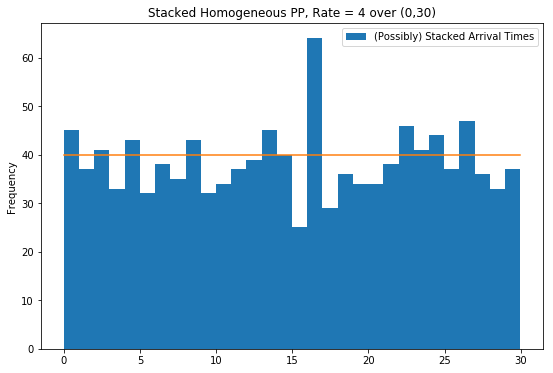

1155  arrivals has MLE mu = 1155  / 30*10 =  3.85


In [5]:
n=10
f = lambda x:4
all_arrivals = list(chain.from_iterable([gen_NHPP_thinning(f, 0, 30, 4) for i in range(n)]))
plot(all_arrivals, 30, lambda x:n*f(x), "Stacked Homogeneous PP, Rate = 4 over (0,30)")
print(len(all_arrivals), " arrivals has MLE mu =", len(all_arrivals), " / 30*10 = ", len(all_arrivals)/(30.*10))
all_arrivals = list(chain.from_iterable([gen_NHPP_thinning(lambda x:np.abs(2*np.sin(x)), 0, 12, 2) for i in range(10)]))

# achtung! number of bins influences how high the counts appear
# for now use bins= approx (b-a)




0.08737279114081405 11.9666194443683


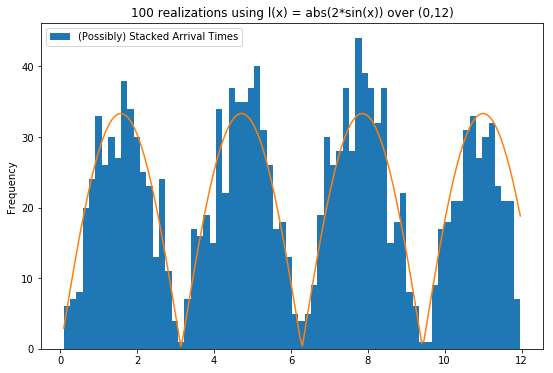

1565  arrivals has fixed MLE lambda = 1565  / 12*10 =  13.041666666666666


In [6]:
n, f = 100, lambda x:np.abs(2*np.sin(x))
stacked_arrivals = list(chain.from_iterable([gen_NHPP_thinning(f, 0, 12, 2) for i in range(100)]))
plot(stacked_arrivals, 6*12, lambda x:n*f(x)/6, "%d realizations using l(x) = abs(2*sin(x)) over (0,12)" % n)
print(len(stacked_arrivals), " arrivals has fixed MLE lambda =", len(stacked_arrivals), " / 12*10 = ", len(stacked_arrivals)/(120))


In [7]:
print("We have data!")
a=pd.read_csv("realizations.csv")
a.transpose().head()

We have data!


0         1         2         3         4         5         6  \
0  1.204380  1.642145  2.528768  3.990939  4.878109  5.023995  5.874906   
1  1.292257  1.422252  1.847798  1.883461  2.809613  2.909013  3.818215   
2  0.401820  1.332935  1.678053  2.191499  2.722110  3.903959  4.161918   
3  1.160994  1.467350  1.691366  2.579278  4.763275  7.267197  7.816846   
4  0.913565  1.471901  3.804400  4.613016  4.755631  5.398339  5.421317   

           7  
0   6.960018  
1   4.287654  
2   4.237809  
3  11.231147  
4   7.121584

**In conclusion**

More important than the quantity of realizations generated is the variety of families of rate functions that we are able to generate.

In the aim of estimating demand, the most common rate function used in dynamic pricing intensity control literature is log-linear in price (e^(a-bx)). Linear families are not difficult to produce. We have implemented a few below

Edge cases will give us the clearest ideas of what will break our distribution.



In [8]:
def get_log_linear(alpha, beta):
    return lambda x:np.exp(alpha-beta*x)

def get_linear(alpha, beta):
    return lambda x:alpha-beta*x

# unbounded difference quotients, don't use thinning
def get_beta(interval, cumulative_intensity, alpha=.5, beta=.5): 
    from scipy.stats import beta as beta_d
    a, b, beta = *interval, beta_d(alpha, beta)
    return lambda x: beta.pdf((x-a)/(b-a))*cumulative_intensity / (b-a)